In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os

In [ ]:
PATH_FAREND   = 'farend_speech_fileid_0.wav'      # Tín hiệu tham chiếu (Reference
PATH_MIC      = 'nearend_mic_fileid_0.wav' # Tín hiệu thu được (Mic = Echo + Voice)
PATH_OUTPUT   = 'output_aec.wav'
DTD_THRESHOLD = 2.0
FILTER_LENGTH = 16384
STEP_SIZE     = 0.001

In [32]:
def load_audio(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Không tìm thấy file: {path}")
    
    fs, audio = wavfile.read(path)
    
    # Chuyển đổi sang Mono nếu là Stereo
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
        
    # Chuyển đổi sang Float [-1.0, 1.0]
    if audio.dtype == np.int16:
        audio = audio.astype(np.float32) / 32768.0
    elif audio.dtype == np.int32:
        audio = audio.astype(np.float32) / 2147483648.0
        
    return fs, audio

def save_audio(path, data, fs):
    data_int16 = np.int16(data * 32767)
    wavfile.write(path, fs, data_int16)
    print(f"-> Đã lưu kết quả tại: {path}")

In [ ]:
def run_nlms_dtd(mic_signal, farend_signal, filter_len, mu, dtd_thresh):
    n_samples = len(mic_signal)
    w = np.zeros(filter_len)
    output_e = np.zeros(n_samples)
    max_far_energy = 0
    dtd_hold_counter = 0
    HOLD_TIME = 100 
    
    print("Đang chạy AEC với Double-Talk Detector...")
    
    for n in range(filter_len, n_samples):
        x_n = farend_signal[n : n - filter_len : -1]
        
        y_n = np.dot(w, x_n)
        e_n = mic_signal[n] - y_n
        output_e[n] = e_n

        curr_far_abs = np.max(np.abs(x_n))
        curr_mic_abs = np.abs(mic_signal[n])
    
        if curr_mic_abs > dtd_thresh * curr_far_abs:
            dtd_hold_counter = HOLD_TIME # Kích hoạt đóng băng
            
        if dtd_hold_counter == 0:
            norm_x = np.dot(x_n, x_n) + 1e-6
            w = w + (mu / norm_x) * e_n * x_n
        else:
            dtd_hold_counter -= 1
    return output_e

Sample Rate: 16000 Hz | Độ dài mẫu: 159999
Đang chạy AEC với Double-Talk Detector...
-> Đã lưu kết quả tại: output_aec.wav


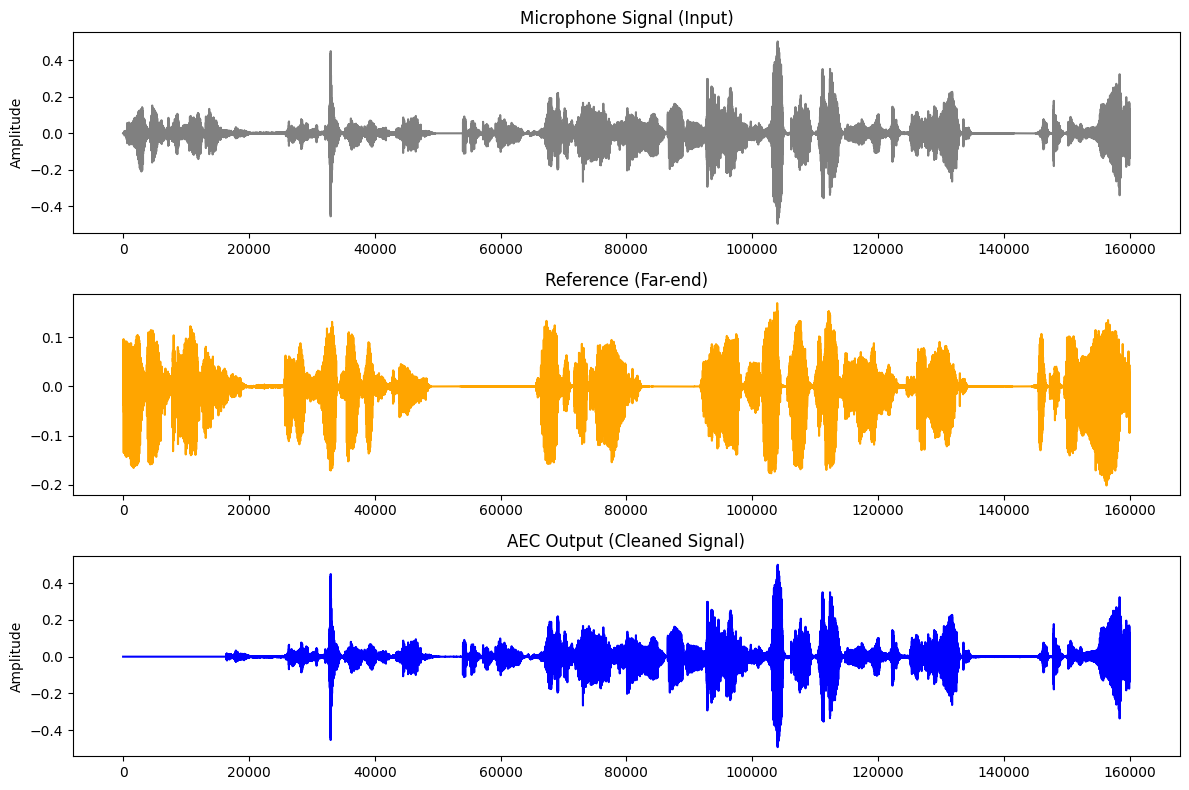

In [36]:
fs_far, x = load_audio(PATH_FAREND)
fs_mic, d = load_audio(PATH_MIC)

if fs_far != fs_mic:
    raise ValueError("Sample rate của 2 file không giống nhau!")

min_len = min(len(x), len(d))
x = x[:min_len]
d = d[:min_len]
print(f"Sample Rate: {fs_far} Hz | Độ dài mẫu: {min_len}")

e = run_nlms_dtd(d, x, FILTER_LENGTH, STEP_SIZE, DTD_THRESHOLD)
save_audio(PATH_OUTPUT, e, fs_mic)
        
# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
        
plt.subplot(3, 1, 1)
plt.title("Microphone Signal (Input)")
plt.plot(d, color='gray')
plt.ylabel("Amplitude")
        
plt.subplot(3, 1, 2)
plt.title("Reference (Far-end)")
plt.plot(x, color='orange')
        
plt.subplot(3, 1, 3)
plt.title("AEC Output (Cleaned Signal)")
plt.plot(e, color='blue')
plt.ylabel("Amplitude")
        
plt.tight_layout()
plt.show()